In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
style.use('seaborn-paper')
print(style.available)
%autosave 60

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


Autosaving every 60 seconds


## Generating Sequences

In [2]:
%%time
n_seq = 400000
#Sequences = generate_Sequences(n_seq)
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")


CPU times: user 3.89 s, sys: 408 ms, total: 4.3 s
Wall time: 4.36 s


In [3]:
Sequences[8000].master_sequence, Sequences[8000].sequence, Sequences[8000].hamming_distance, Sequences[8000].energy_parent, Sequences[8000].energy, Sequences[8000].delta_energy


('odsadmgao',
 'mdnbdmgat',
 4,
 -3.1000000000000014,
 -3.1200000000000014,
 -0.01999999999999999)

In [15]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies = plot_histogram_energy(Sequences = Sequences, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences-n_seq-%d.png'%(n_seq))
plt.close()


## Stochastic Simulation

In [18]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 2
R=6
beta = 1
gamma = 1
T = 20000
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
Model.Gillespie()


CPU times: user 2min 41s, sys: 2min 10s, total: 4min 52s
Wall time: 5min


In [19]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

Model.plot_energy_matrix(ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))
plt.close()


In [20]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(counter))
plt.close()


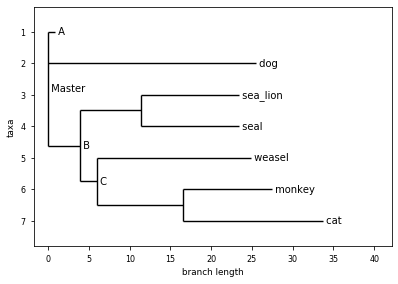

In [21]:
tree = Phylo.read(StringIO("Master(A():0.84600,B((sea_lion:11.99700, seal:12.00300):7.52973,C((monkey:10.85930,cat:17.14069):10.59201, weasel:18.87953):2.09460):3.87382,dog:25.46154):0"), "newick")
tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

## Distribution clone size

In [ ]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 2
R=6
beta = 1
gamma = 1
T = 7
activated_linages_size = []
for i in range(10):
    Sub_Sequences = np.random.choice(Sequences, n_linages)
    Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = 12)
    Model.Gillespie()
    activated_linages_size = np.append(activated_linages_size, [Model.linages_time_series[i,-1] for i in range(n_linages) if Model.Sequences[i].active])

fig, ax = plt.subplots(1,1,figsize=(10,8))
data_activated_linages = np.histogram(activated_linages_size, bins = 100)
ax.plot(data_activated_linages[1][:-1], np.cumsum(data_activated_linages[0]/len(activated_linages_size)), linewidth = 4, color = 'tab:red')
ax.set_xlabel(r'Clone size $n_i$', fontsize = 20)
ax.set_ylabel(r'probability', fontsize = 20)
ax.tick_params(labelsize = 20)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig('../Figures/Linages_size_distribution.png')